# Correct Dataset from Validation Report

[![Jupyter Notebook](https://img.shields.io/badge/jupyter-%23FA0F00.svg?style=for-the-badge&logo=jupyter&logoColor=white)](https://github.com/openvinotoolkit/datumaro/blob/develop/notebooks/12_correct_dataset.ipynb)

In this notebook example, we will demonstrate how to rectify a dataset using a pre-generated validation report. The report is designed to analyze various types of anomalies in the data, as shown in the previous [notebook example](https://github.com/openvinotoolkit/datumaro/blob/develop/notebooks/11_validate.ipynb). By leveraging this report, we can enhance the dataset by addressing issues like undefined labels, missing annotations, and statistical outliers.

## Prerequisite 
### Download COCO 2017 validation dataset 
Please refer [this notebook](https://openvinotoolkit.github.io/datumaro/latest/docs/jupyter_notebook_examples/notebooks/03_visualize.html) for preparing COCO 2017 validation dataset.

In [60]:
from datumaro.components.dataset import Dataset

path = "coco_dataset"
dataset = Dataset.import_from(path, "coco_instances")

print("Representation for sample COCO dataset")
dataset

Representation for sample COCO dataset


Dataset
	size=5000
	source_path=coco_dataset
	media_type=<class 'datumaro.components.media.Image'>
	annotated_items_count=4952
	annotations_count=78647
subsets
	val2017: # of items=5000, # of annotated items=4952, # of annotations=78647, annotation types=['polygon', 'bbox', 'mask']
infos
	categories
	label: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 

### Generate the validation report 

As following the previous example, we then generate the validation report per severity (error, warning, and info) and various anomaly types. In this example, we are going to resolve the errors and warnings through `correct` transformation.

In [61]:
from datumaro.plugins.validators import DetectionValidator

extra_args = {
    "few_samples_thr": 100,
    "imbalance_ratio_thr": 5,
    "far_from_mean_thr": 10.0,
}

validator = DetectionValidator(**extra_args)


def validate(dataset):
    reports = validator.validate(dataset)

    print("Validation report summary:", reports["summary"])

    error_cnt = {}
    warning_cnt = {}
    info_cnt = {}
    for report in reports["validation_reports"]:
        if report["severity"] == "error":
            type = report["anomaly_type"]
            if error_cnt.get(type) is None:
                error_cnt[type] = 1
            else:
                error_cnt[type] += 1
        if report["severity"] == "warning":
            type = report["anomaly_type"]
            if warning_cnt.get(type) is None:
                warning_cnt[type] = 1
            else:
                warning_cnt[type] += 1
        if report["severity"] == "info":
            type = report["anomaly_type"]
            if info_cnt.get(type) is None:
                info_cnt[type] = 1
            else:
                info_cnt[type] += 1
    print("The number of reports per error type: ", error_cnt)
    print("The number of reports per warning type: ", warning_cnt)
    print("The number of reports per info type: ", info_cnt)

    return reports


reports = validate(dataset)

Validation report summary: {'errors': 36782, 'warnings': 105, 'infos': 69}
The number of reports per error type:  {'UndefinedAttribute': 36781, 'NegativeLength': 1}
The number of reports per warning type:  {'MissingAnnotation': 48, 'FarFromLabelMean': 57}
The number of reports per info type:  {'FewSamplesInLabel': 9, 'ImbalancedLabels': 1, 'ImbalancedDistInLabel': 59}


### Visualize some anomalies

Let's visually check how serious the abnormal samples are for a few examples.

  warnings.warn(msg)



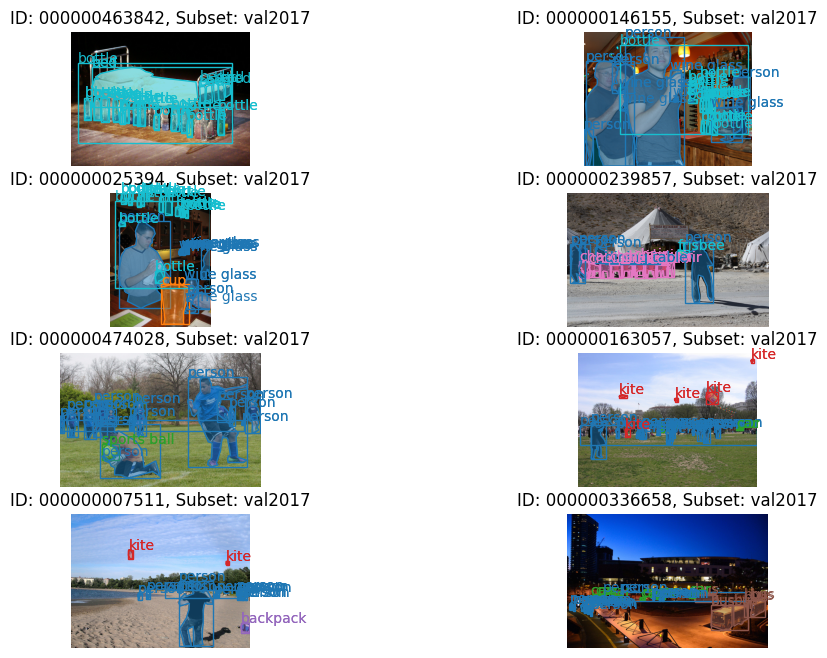

In [62]:
from datumaro.components.annotation import AnnotationType
from datumaro.components.visualizer import Visualizer

far_from_mean_ids = []
far_from_mean_subsets = []
for report in reports["validation_reports"]:
    if report["anomaly_type"] == "FarFromLabelMean":
        if report["item_id"] in far_from_mean_ids:
            continue
        far_from_mean_ids.append(report["item_id"])
        far_from_mean_subsets.append(report["subset"])

visualizer = Visualizer(dataset, figsize=(12, 8), ignored_types=[AnnotationType.mask], alpha=0.5)
fig = visualizer.vis_gallery(far_from_mean_ids[:8], far_from_mean_subsets[:8])
fig.show()

## Correct anomalies

Among the many transformations provided by Datumaro, `correct` transformation corrects anomalies as shown in the table below.

| Anomaly type                | Description                                                                   | Task                    | Type    | Target   | Operation |
|-----------------------------|-------------------------------------------------------------------------------|-------------------------|---------|----------|-----------|
| MissingLabelCategories      | Metadata (ex. LabelCategories) should be defined                              | common                  | error   | category | add       |
| MissingAnnotation           | No annotation found for an Item                                               | common                  | warning | item     | remove    |
| MissingAttribute            | An attribute key is missing for an Item                                       | common                  | warning | item     | add       |
| UndefinedLabel              | A label not defined in the metadata is found for an item                      | common                  | error   | category | add       |
| UndefinedAttribute          | An attribute not defined in the metadata is found for an item                 | common                  | error   | category | add       |
| MultiLabelAnnotations       | Item needs a single label                                                     | classification          | error   | item     | remove    |
| NegativeLength              | The width or height of bounding box is negative                               | detection               | error   | ann      | remove    |
| InvalidValue                | There’s invalid (ex. inf, nan) value for bounding box info.                   | detection               | error   | ann      | remove    |
| FarFromLabelMean            | An annotation has an too small or large value than average for a label        | detection, segmentation | warning | ann      | remove    |
| FarFromAttrMean             | An annotation has an too small or large value than average for an attribute   | detection, segmentation | warning | ann      | remove    |
| LabelDefinedButNotFound     | A label is defined, but not found actually                                    | common                  | warning |          |           |
| AttributeDefinedButNotFound | An attribute is defined, but not found actually                               | common                  | warning |          |           |
| OnlyOneLabel                | The dataset consists of only label                                            | common                  | info    | -        | -         |
| OnlyOneAttributeValue       | The dataset consists of only attribute value                                  | common                  | info    | -        | -         |
| FewSamplesInLabel           | The number of samples in a label might be too low                             | common                  | info    | -        | -         |
| FewSamplesInAttribute       | The number of samples in an attribute might be too low                        | common                  | info    | -        | -         |
| ImbalancedLabels            | There is an imbalance in the label distribution                               | common                  | info    | -        | -         |
| ImbalancedAttribute         | There is an imbalance in the attribute distribution                           | common                  | info    | -        | -         |
| ImbalancedDistInLabel       | Values (ex. bbox width) are not evenly distributed for a label                | detection, segmentation | info    | -        | -         |
| ImbalancedDistInAttribute   | Values (ex. bbox width) are not evenly distributed for an attribute           | detection, segmentation | info    | -        | -         |

In [63]:
import datumaro.plugins.transforms as transforms

refined_dataset = transforms.Correct(dataset, reports=reports)

reports = validate(refined_dataset)

Validation report summary: {'errors': 0, 'warnings': 58, 'infos': 281}
The number of reports per error type:  {}
The number of reports per warning type:  {'MissingAnnotation': 1, 'FarFromLabelMean': 33, 'FarFromAttrMean': 24}
The number of reports per info type:  {'FewSamplesInLabel': 9, 'ImbalancedLabels': 1, 'FewSamplesInAttribute': 49, 'ImbalancedAttribute': 41, 'OnlyOneAttributeValue': 39, 'ImbalancedDistInLabel': 48, 'ImbalancedDistInAttribute': 94}


Because of dataset reduction according to some anomalies such as `NegativeLength` or `InvalideValue`, the overall statistics can be also updated and it yields another anomalies as shown above (one `FarFromLabelMean` and another `FarFromAttrMean`). These can be refined again through one more refinement cycle as below.

In [64]:
second_refined_dataset = transforms.Correct(refined_dataset, reports=reports)

reports = validate(second_refined_dataset)

Validation report summary: {'errors': 0, 'warnings': 21, 'infos': 276}
The number of reports per error type:  {}
The number of reports per warning type:  {'FarFromLabelMean': 12, 'FarFromAttrMean': 9}
The number of reports per info type:  {'FewSamplesInLabel': 9, 'ImbalancedLabels': 1, 'FewSamplesInAttribute': 49, 'ImbalancedAttribute': 41, 'OnlyOneAttributeValue': 39, 'ImbalancedDistInLabel': 45, 'ImbalancedDistInAttribute': 92}


We further check that some noisy bounding box annotations of having extreme aspect ratios is well cleaned below.

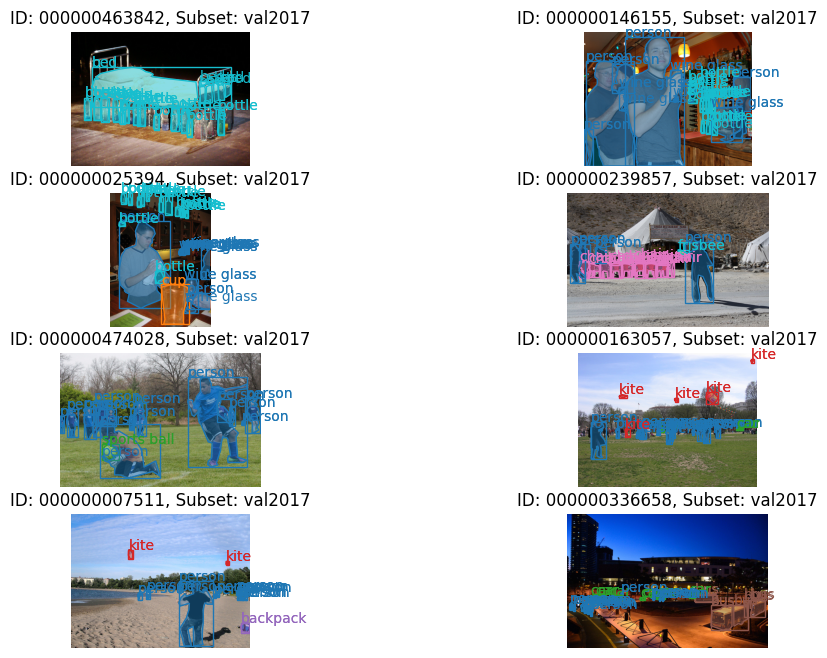

In [65]:
visualizer = Visualizer(
    second_refined_dataset, figsize=(12, 8), ignored_types=[AnnotationType.mask], alpha=0.5
)
fig = visualizer.vis_gallery(far_from_mean_ids[:8], far_from_mean_subsets[:8])
fig.show()